# Optimization with Atomic Orbital Search (AOS)

## Required Libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from niapy.task import Task
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm

## Atomic Orbital Search Implementation

In [2]:
# Atomic Orbital Search (AOS) Class
class AtomicOrbitalSearch:
    def __init__(self, cost_function, var_number=2, var_min=-5, var_max=5, max_fes=100000, n_pop=25, layer_number=5, foton_rate=0.1):
        self.cost_function = cost_function
        self.var_number = var_number
        self.var_min = var_min * np.ones(var_number)
        self.var_max = var_max * np.ones(var_number)
        self.max_fes = max_fes
        self.n_pop = n_pop
        self.layer_number = layer_number
        self.foton_rate = foton_rate
        
        # Initialization
        self.pop = np.random.uniform(self.var_min, self.var_max, (n_pop, var_number))
        self.cost = np.array([self.cost_function(ind) for ind in self.pop])
        self.fes = n_pop  # Function Evaluations
        self.best_pop = None
        self.best_cost = float('inf')
        self.best_costs = []
        self.iteration_candidates = []  # To store candidates for plotting

    def run(self):
        # Sort Population
        sorted_indices = np.argsort(self.cost)
        self.pop = self.pop[sorted_indices]
        self.cost = self.cost[sorted_indices]
        self.best_pop = self.pop[0]
        self.best_cost = self.cost[0]
        
        # Main Loop
        iter = 0
        while self.fes < self.max_fes:
            iter += 1
            pop_c = []
            cost_c = []
            self.iteration_candidates.append(np.copy(self.pop))  # Store current candidates
            
            # Create Quantum Layers
            max_lay = np.random.randint(1, self.layer_number + 1)
            nor_disp = np.exp(-np.arange(max_lay) / (max_lay / 6))
            nor_disp /= np.sum(nor_disp)  # Normalize
            nor_disp_cal = np.round(nor_disp * self.n_pop).astype(int)
            lay_col = np.concatenate(([0], np.cumsum(nor_disp_cal)))  # límites de las capas
            lay_col[lay_col > self.n_pop] = self.n_pop  # asegura de que no exceda la población total
            
            # Search Loop
            for i in range(max_lay):
                pop_a = self.pop[lay_col[i]:lay_col[i + 1]]  # soluciones que pertenecen a la capa i
                cost_a = self.cost[lay_col[i]:lay_col[i + 1]]  # coste de soluciones de la capa i
                energy = np.mean(cost_a)  # energía promedio de la capa i
                orbit = i + 1  # Layer index (starting from 1)

                for j in range(len(pop_a)):  # para cada solución (electrón) de la capa i
                    if np.random.rand() > self.foton_rate:  # interacción con fotones
                        if cost_a[j] > energy:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = self.best_pop
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean) / orbit)
                        else:
                            ir = np.random.rand(2)
                            jr = np.random.rand(self.var_number)
                            x_old = pop_a[j]
                            x_best = pop_a[0]
                            x_mean = np.mean(pop_a, axis=0) if len(pop_a) > 1 else pop_a[0]
                            pop_b = x_old + (jr * (ir[0] * x_best - ir[1] * x_mean))
                    else:
                        pop_b = np.random.uniform(self.var_min, self.var_max, self.var_number)

                    # Apply bounds
                    pop_b = np.clip(pop_b, self.var_min, self.var_max)
                    cost_b = self.cost_function(pop_b)
                    self.fes += 1
                    
                    # Store results
                    pop_c.append(pop_b)
                    cost_c.append(cost_b)

            # Merge Candidates
            self.pop = np.vstack((self.pop, pop_c))
            self.cost = np.concatenate((self.cost, cost_c))

            # Sort Population
            sorted_indices = np.argsort(self.cost)
            self.pop = self.pop[sorted_indices]
            self.cost = self.cost[sorted_indices]
            self.best_pop = self.pop[0]
            self.best_cost = self.cost[0]
            self.best_costs.append(self.best_cost)

            # Truncate population
            self.pop = self.pop[:self.n_pop]
            self.cost = self.cost[:self.n_pop]

            # Show Iteration Information
            # print(f"Iteration {iter}: Best Cost = {self.best_cost}")

        return self.best_pop, self.best_cost, self.best_costs

# Plotting convergence
def plot_convergence(best_costs):
    plt.figure(figsize=(10, 6))
    plt.plot(best_costs, color='blue', linewidth=2)
    plt.title('Convergence Plot')
    plt.xlabel('Iteration')
    plt.ylabel('Best Cost')
    plt.grid(True)
    plt.show()

## Test functions

In [3]:
def test_functions(X, fun_index, dim=None):
    """
    Compute the fitness value for a given input vector `X` and a specific benchmark function.

    Parameters:
    - X: ndarray, Input vector
    - fun_index: int, Index of the function to evaluate
    - dim: int, Dimension of the input vector (default is derived from X if not provided)

    Returns:
    - Fit: float, The fitness value
    """
    if dim is None:
        dim = len(X)

    if fun_index == 1:  # Sphere
        Fit = np.sum(X ** 2)

    elif fun_index == 2:  # Schwefel 2.22
        Fit = np.sum(np.abs(X)) + np.prod(np.abs(X))

    elif fun_index == 3:  # Schwefel 1.2
        Fit = sum([np.sum(X[:i + 1]) ** 2 for i in range(dim)])

    elif fun_index == 4:  # Schwefel 2.21
        Fit = np.max(np.abs(X))

    elif fun_index == 5:  # Rosenbrock
        Fit = np.sum(100 * (X[1:] - X[:-1] ** 2) ** 2 + (X[:-1] - 1) ** 2)

    elif fun_index == 6:  # Step
        Fit = np.sum(np.floor(X + 0.5) ** 2)

    elif fun_index == 7:  # Quartic
        Fit = np.sum(np.arange(1, dim + 1) * (X ** 4)) + np.random.rand()

    elif fun_index == 8:  # Schwefel
        Fit = np.sum(-X * np.sin(np.sqrt(np.abs(X))))

    elif fun_index == 9:  # Rastrigin
        Fit = np.sum(X ** 2 - 10 * np.cos(2 * np.pi * X)) + 10 * dim

    elif fun_index == 10:  # Ackley
        Fit = -20 * np.exp(-0.2 * np.sqrt(np.sum(X ** 2) / dim)) - \
              np.exp(np.sum(np.cos(2 * np.pi * X)) / dim) + 20 + np.e

    elif fun_index == 11:  # Griewank
        Fit = np.sum(X ** 2) / 4000 - np.prod(np.cos(X / np.sqrt(np.arange(1, dim + 1)))) + 1

    elif fun_index == 12:  # Penalized
        a, k, m = 10, 100, 4
        y = 1 + (X + 1) / 4
        Fit = (np.pi / dim) * (
            10 * (np.sin(np.pi * y[0]) ** 2) + 
            np.sum((y[:-1] - 1) ** 2 * (1 + 10 * (np.sin(np.pi * y[1:]) ** 2))) +
            (y[-1] - 1) ** 2
        ) + np.sum(k * ((X > a) * ((X - a) ** m) + (X < -a) * ((-X - a) ** m)))

    elif fun_index == 13:  # Penalized2
        a, k, m = 10, 100, 4
        Fit = 0.1 * (
            np.sin(3 * np.pi * X[0]) ** 2 +
            np.sum((X[:-1] - 1) ** 2 * (1 + np.sin(3 * np.pi * X[1:]) ** 2)) +
            (X[-1] - 1) ** 2 * (1 + np.sin(2 * np.pi * X[-1]) ** 2)
        ) + np.sum(k * ((X > a) * ((X - a) ** m) + (X < -a) * ((-X - a) ** m)))

    elif fun_index == 14:  # Foxholes
        a = np.array([[-32, -16, 0, 16, 32] * 5, [-32] * 5 + [-16] * 5 + [0] * 5 + [16] * 5 + [32] * 5])
        b = np.sum((X.reshape(-1, 1) - a) ** 6, axis=0)
        Fit = (1 / 500 + np.sum(1 / (np.arange(1, 26) + b))) ** (-1)

    elif fun_index == 15:  # Kowalik
        a = np.array([0.1957, 0.1947, 0.1735, 0.16, 0.0844, 0.0627, 0.0456, 0.0342, 0.0323, 0.0235, 0.0246])
        b = 1 / np.array([0.25, 0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16])
        Fit = np.sum((a - ((X[0] * (b ** 2 + X[1] * b)) / (b ** 2 + X[2] * b + X[3]))) ** 2)

    elif fun_index == 16:  # Six Hump Camel
        Fit = (4 * X[0] ** 2 - 2.1 * X[0] ** 4 + (X[0] ** 6) / 3 + X[0] * X[1] -
            4 * X[1] ** 2 + 4 * X[1] ** 4)

    elif fun_index == 17:  # Branin
        Fit = ((X[1] - (5.1 / (4 * np.pi ** 2)) * X[0] ** 2 + (5 / np.pi) * X[0] - 6) ** 2 +
            10 * (1 - 1 / (8 * np.pi)) * np.cos(X[0]) + 10)

    elif fun_index == 18:  # Goldstein-Price
        Fit = ((1 + (X[0] + X[1] + 1) ** 2 * (19 - 14 * X[0] + 3 * X[0] ** 2 - 14 * X[1] +
                                            6 * X[0] * X[1] + 3 * X[1] ** 2)) *
            (30 + (2 * X[0] - 3 * X[1]) ** 2 * (18 - 32 * X[0] + 12 * X[0] ** 2 + 48 * X[1] -
                                                36 * X[0] * X[1] + 27 * X[1] ** 2)))

    elif fun_index == 19:  # Hartman 3
        a = np.array([[3, 10, 30], [0.1, 10, 35], [3, 10, 30], [0.1, 10, 35]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.3689, 0.117, 0.2673], [0.4699, 0.4387, 0.747], [0.1091, 0.8732, 0.5547], [0.03815, 0.5743, 0.8828]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index == 20:  # Hartman 6
        a = np.array([[10, 3, 17, 3.5, 1.7, 8], [0.05, 10, 17, 0.1, 8, 14], [3, 3.5, 1.7, 10, 17, 8],
                    [17, 8, 0.05, 10, 0.1, 14]])
        c = np.array([1, 1.2, 3, 3.2])
        p = np.array([[0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
                    [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
                    [0.2348, 0.1415, 0.3522, 0.2883, 0.3047, 0.6650],
                    [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381]])
        Fit = -np.sum([c[i] * np.exp(-np.sum(a[i, :] * (X - p[i, :]) ** 2)) for i in range(4)])

    elif fun_index in [21, 22]:  # Shekel 5, 7, 10
        a = np.array([[4, 4, 4, 4], [1, 1, 1, 1], [8, 8, 8, 8], [6, 6, 6, 6],
                    [3, 7, 3, 7], [2, 9, 2, 9], [5, 5, 3, 3], [8, 1, 8, 1],
                    [6, 2, 6, 2], [7, 3.6, 7, 3.6]])
        c = np.array([0.1, 0.2, 0.2, 0.4, 0.4, 0.6, 0.3, 0.7, 0.5, 0.5])
        m = 5 if fun_index == 21 else (7 if fun_index == 22 else 10)
        Fit = -np.sum([1 / (np.sum((X - a[i, :]) ** 2) + c[i]) for i in range(m)])

    else:
        raise ValueError("Invalid function index.")

    return Fit


def test_functions_range(fun_index):
    """
    Get the range and default dimension for a given benchmark function index.

    Parameters:
    - fun_index: int, Index of the function

    Returns:
    - low: float or ndarray, Lower bound(s) of the input space
    - up: float or ndarray, Upper bound(s) of the input space
    - dim: int, Default dimension
    """
    dim = 30  # Default dimension
    if fun_index == 1:
        low, up = -100, 100
    elif fun_index == 2:
        low, up = -10, 10
    elif fun_index == 3:
        low, up = -100, 100
    elif fun_index == 4:
        low, up = -100, 100
    elif fun_index == 5:
        low, up = -30, 30
    elif fun_index == 6:
        low, up = -100, 100
    elif fun_index == 7:
        low, up = -1.28, 1.28
    elif fun_index == 8:
        low, up = -500, 500
    elif fun_index == 9:
        low, up = -5.12, 5.12
    elif fun_index == 10:
        low, up = -32, 32
    elif fun_index == 11:
        low, up = -600, 600
    elif fun_index == 12 or fun_index == 13:
        low, up = -50, 50
    elif fun_index == 14:
        low, up = -65.536, 65.536
        dim = 2
    elif fun_index == 15:
        low, up = -5, 5
        dim = 4
    elif fun_index == 16:
        low, up = -5, 5
        dim = 2
    elif fun_index == 17:
        low, up = np.array([-5, 0]), np.array([10, 15])
        dim = 2
    elif fun_index == 18:
        low, up = -2, 2
        dim = 2
    elif fun_index == 19:
        low, up = 0, 1
        dim = 3
    elif fun_index == 20:
        low, up = 0, 1
        dim = 6
    elif fun_index in [21, 22]:
        low, up = 0, 10
        dim = 4
    else:
        low, up = 0, 10
        dim = 4

    return low, up, dim


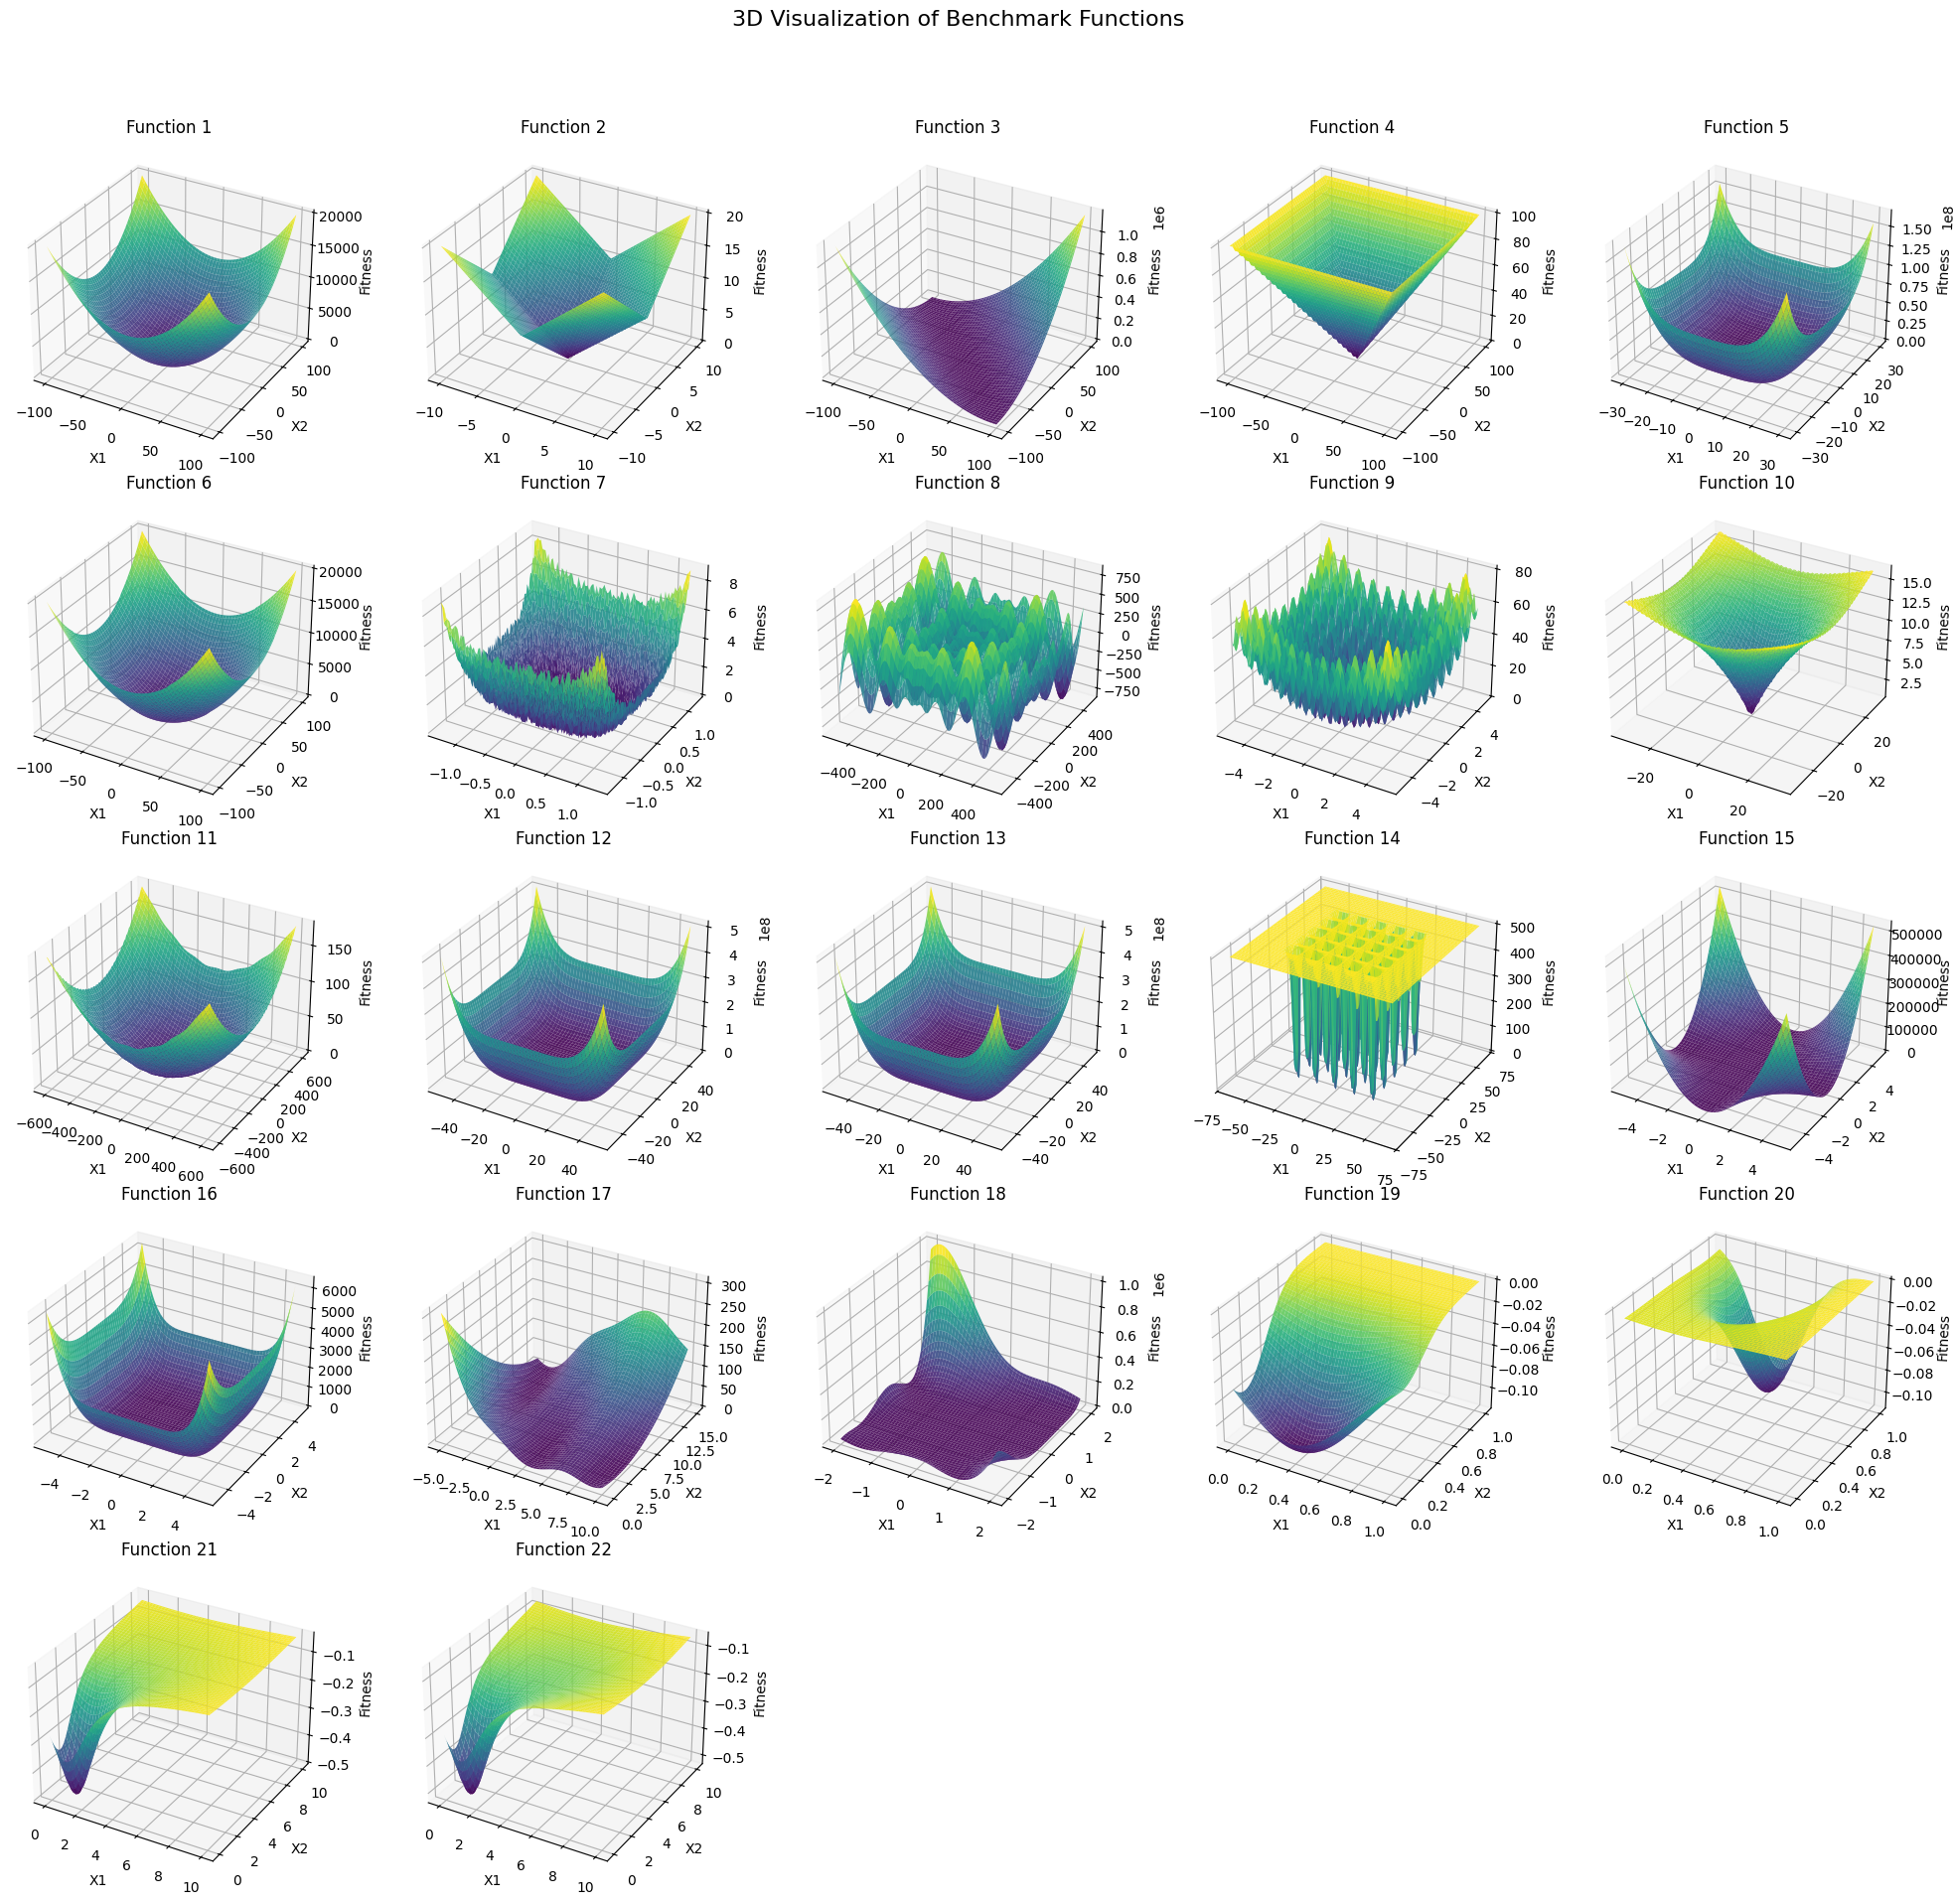

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `test_functions` and `test_functions_range` are defined as above

def plot_functions_in_3d():
    num_functions = 22  # Total number of functions
    rows, cols = 5, 5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("3D Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        # Compute subplot position
        ax = fig.add_subplot(rows, cols, fun_index, projection='3d')
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the 3D surface
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
        ax.set_title(f"Function {fun_index}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("Fitness")
        #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the 3D plotting function
plot_functions_in_3d()


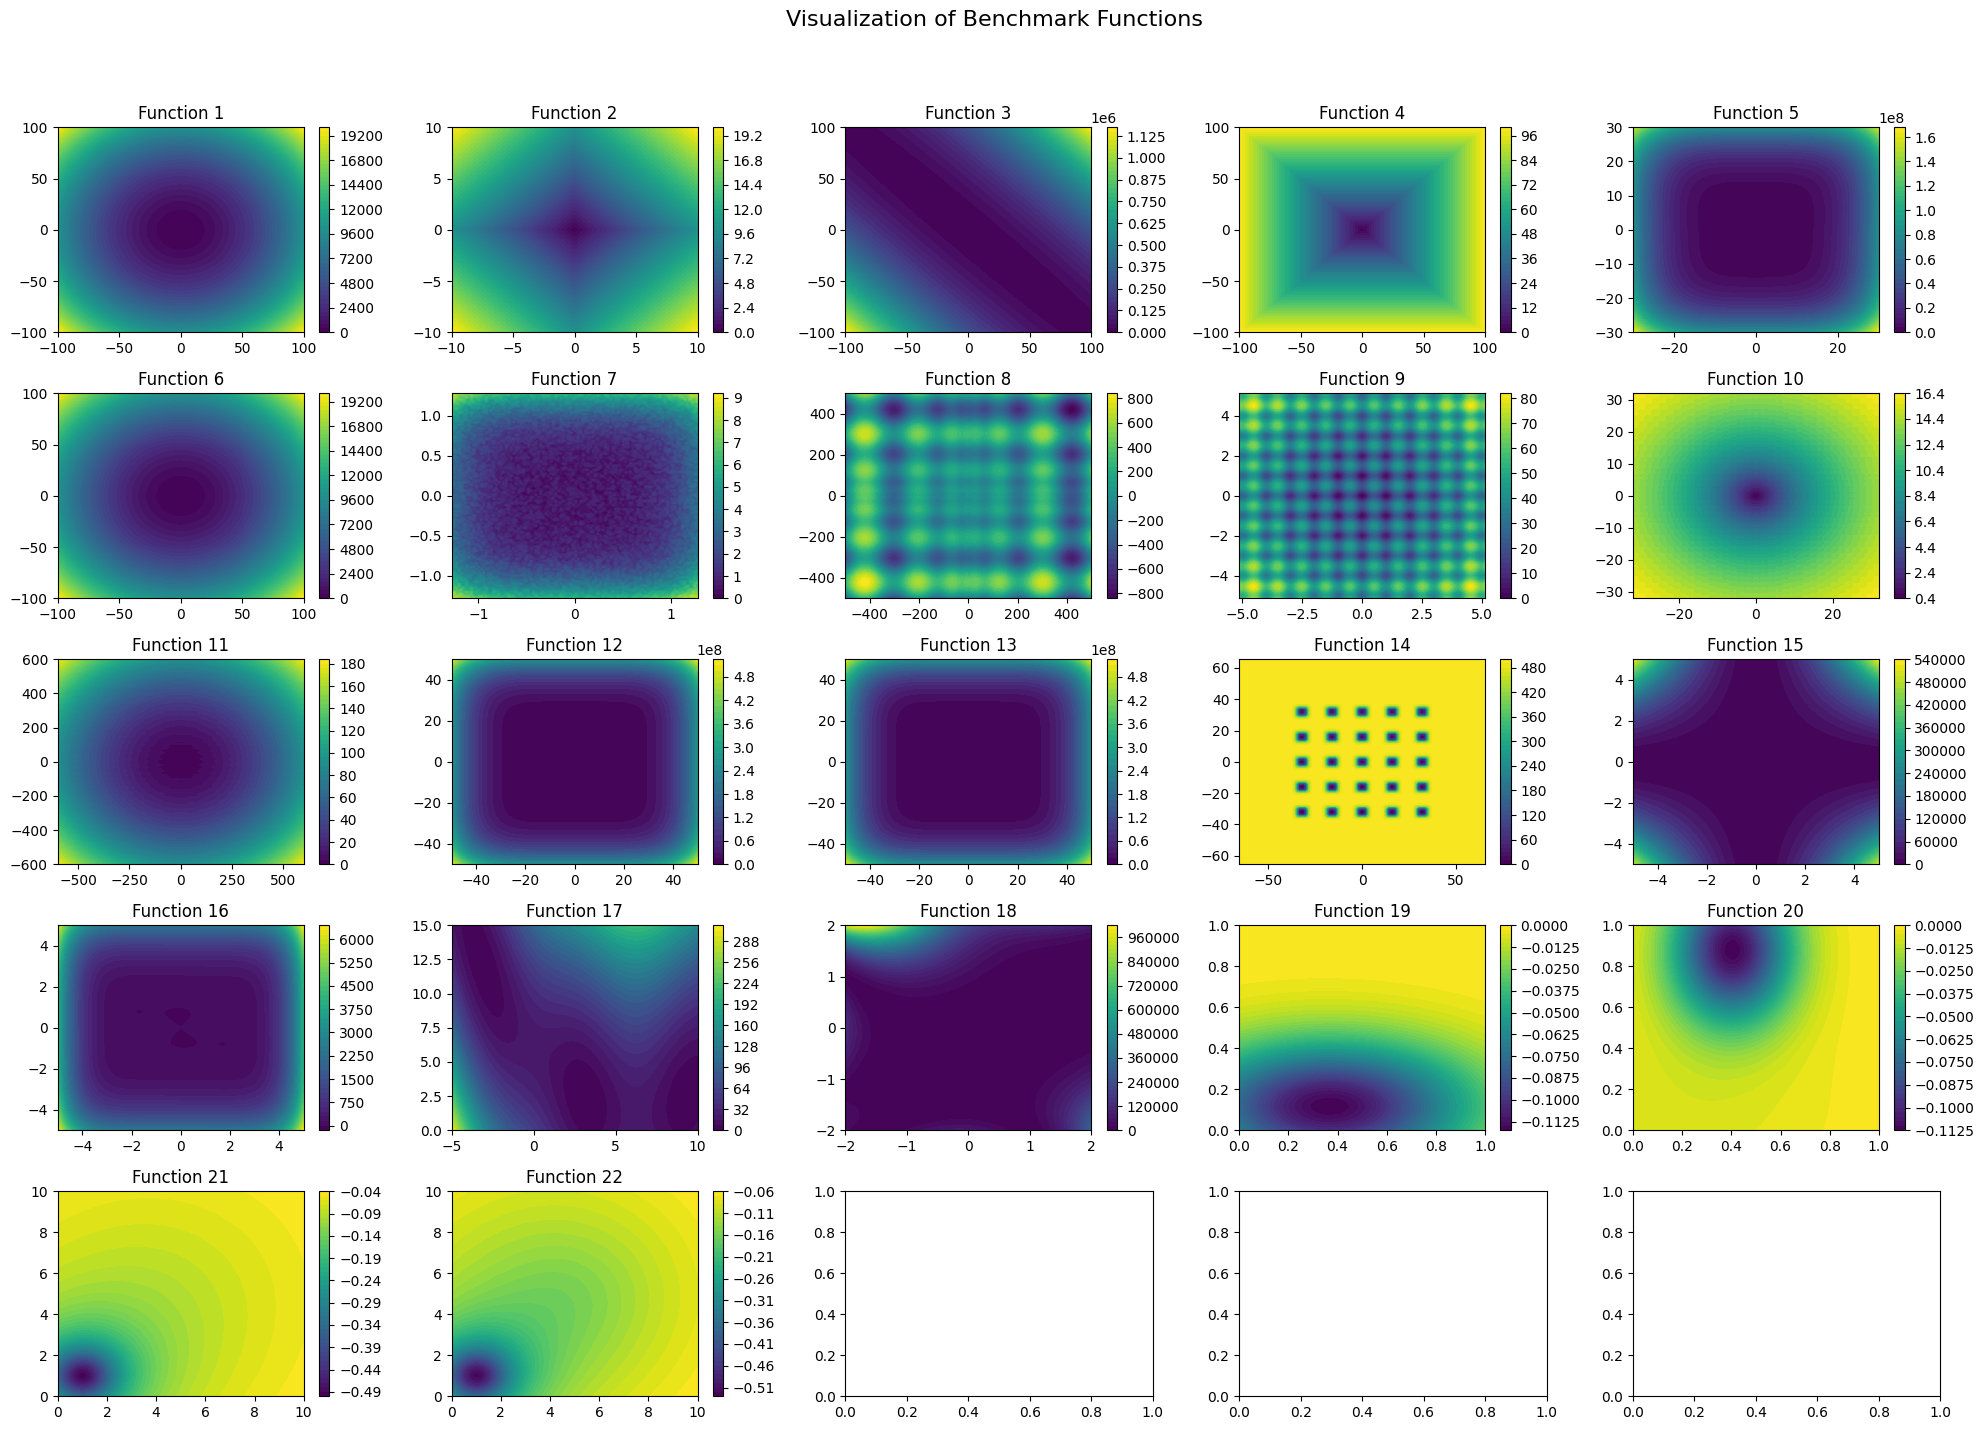

In [5]:
def plot_functions_in_grid():
    num_functions = 22  # Total number of functions
    rows, cols = 5, 5   # Arrange plots in a grid (adjust rows/cols to fit all functions)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    fig.suptitle("Visualization of Benchmark Functions", fontsize=16)
    
    for fun_index in range(1, num_functions + 1):
        row, col = divmod(fun_index - 1, cols)  # Compute subplot position
        ax = axes[row, col]
        
        # Get range and default dimension for this function
        low, up, dim = test_functions_range(fun_index)
        
        # Set up 2D grid (for visualization, we use the first two dimensions)
        x = np.linspace(low[0] if isinstance(low, np.ndarray) else low,
                        up[0] if isinstance(up, np.ndarray) else up, 100)
        y = np.linspace(low[1] if isinstance(low, np.ndarray) and len(low) > 1 else low,
                        up[1] if isinstance(up, np.ndarray) and len(up) > 1 else up, 100)
        X, Y = np.meshgrid(x, y)
        
        # Flatten grid and prepare inputs for the function
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                point = np.zeros(dim)
                point[0] = X[i, j]
                if dim > 1:
                    point[1] = Y[i, j]
                Z[i, j] = test_functions(point, fun_index, dim)
        
        # Plot the function
        c = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
        ax.set_title(f"Function {fun_index}")
        ax.axis('tight')
        fig.colorbar(c, ax=ax, orientation='vertical')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the plotting function
plot_functions_in_grid()


## Parameter optimization using ABC

### AOS

In [6]:
import numpy as np

def select_test_function(fun_index):
    """
    Selects a test function and its parameter ranges by index.

    Parameters:
    - fun_index: int, Index of the benchmark function.

    Returns:
    - function: Callable, The benchmark function.
    - low: float or ndarray, Lower bound(s) of the input space.
    - up: float or ndarray, Upper bound(s) of the input space.
    - dim: int, Default dimension of the input space.
    """
    # Get the parameter ranges and dimensions for the selected function
    low, up, dim = test_functions_range(fun_index)

    # Define the function to use
    def function(X):
        return test_functions(X, fun_index, dim)

    return function, low, up, dim


In [58]:
def aos_objective(params, fun_index):
    """
    Objective function to evaluate AOS performance with given parameters.

    Parameters:
    - params: List of AOS parameters [n_pop, layer_number, foton_rate].

    Returns:
    - best_cost: The best cost achieved by AOS with the given parameters.
    """
    n_pop = int(params[0])        # Population size
    layer_number = int(params[1]) # Number of quantum layers
    foton_rate = params[2]        # Photon interaction rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Instantiate and run AOS
    aos = AtomicOrbitalSearch(
        cost_function=function,
        var_number=var_number,
        var_min=var_min,
        var_max=var_max,
        max_fes=10000,
        n_pop=n_pop,
        layer_number=layer_number,
        foton_rate=foton_rate
    )
    _, best_cost, _ = aos.run()

    return best_cost  # Return the best cost as the objective value


In [60]:
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import ArtificialBeeColonyAlgorithm

# Define the problem class for AOS parameter optimization
class AOSParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: n_pop, layer_number, foton_rate)
        # and bounds for each parameter
        super().__init__(dimension=3, lower=[10, 1, 0.01], upper=[100, 10, 0.5])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the AOS objective function
        return aos_objective(x, self.fun_index)
    
fun_index = 9  # Select the benchmark function to optimize

# Create a task for the ABC algorithm
task = Task(problem=AOSParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm
abc = ArtificialBeeColonyAlgorithm(population_size=20)
best_params, best_cost = abc.run(task=task)

print(f"Optimized Parameters: {best_params}")
print(f"Best Cost Achieved: {best_cost}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimized Parameters: [11.29304102  1.56981565  0.42227006]
Best Cost Achieved: 0.0


Validated Best Cost: 0.0


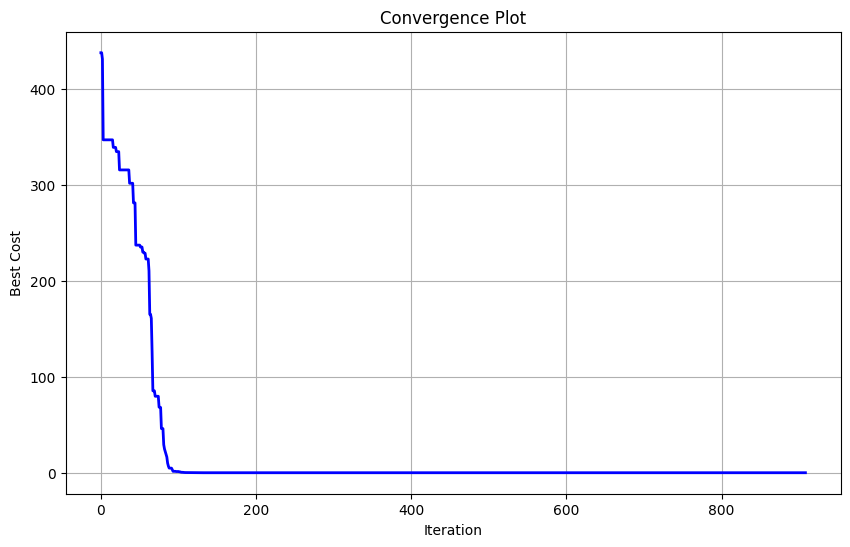

In [61]:
n_pop, layer_number, foton_rate = int(best_params[0]), int(best_params[1]), best_params[2]
fun_index = 9  # Example: Rastrigin function
# Validate AOS with optimized parameters
function, var_min, var_max, var_number = select_test_function(fun_index)
aos = AtomicOrbitalSearch(
    cost_function=function,
    var_number=var_number,
    var_min=var_min,
    var_max=var_max,
    max_fes=10000,
    n_pop=n_pop,
    layer_number=layer_number,
    foton_rate=foton_rate
)
best_solution, best_cost, best_costs = aos.run()

print(f"Validated Best Cost: {best_cost}")
plot_convergence(best_costs)  # Plot convergence if needed


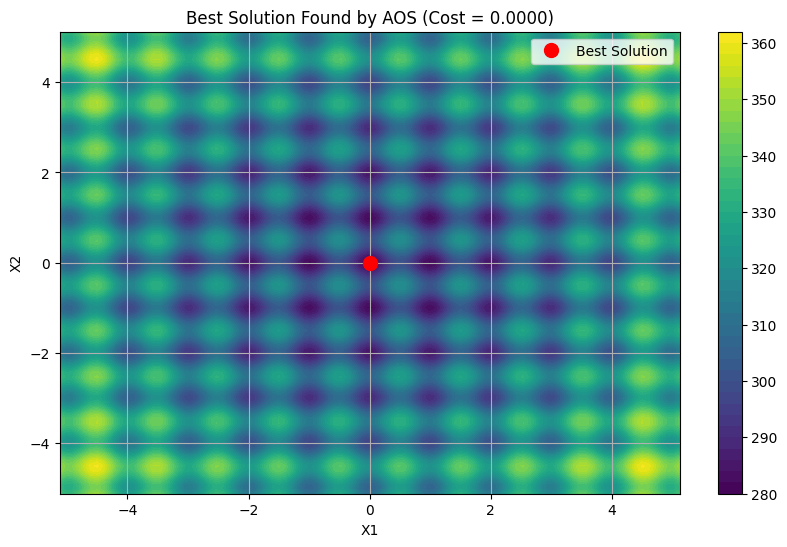

In [62]:
# Show the best solution found by AOS in a 2D plot
def plot_solution_2d(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by AOS (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function
plot_solution_2d(best_solution, best_cost)

### PSO

In [63]:
from niapy.problems import Problem
from pyswarms.single.global_best import GlobalBestPSO

In [65]:
def pso_objective(params, fun_index):
    """
    Objective function to evaluate PSO performance with given parameters.

    Parameters:
    - params: List of PSO parameters [n_particles, inertia, cognitive, social].

    Returns:
    - best_cost: The best cost achieved by PSO with the given parameters.
    """
    n_particles = int(params[0])   # Number of particles
    inertia = params[1]            # Inertia weight
    cognitive = params[2]          # Cognitive coefficient (c1)
    social = params[3]             # Social coefficient (c2)

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Ensure var_min and var_max are arrays
    var_min = np.array([var_min] * var_number) if np.isscalar(var_min) else var_min
    var_max = np.array([var_max] * var_number) if np.isscalar(var_max) else var_max

    # Instantiate and run PSO
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=var_number,
                              options={'c1': cognitive, 'c2': social, 'w': inertia},
                              bounds=(var_min, var_max))
    
    # Perform optimization and get the best cost
    best_cost, _ = optimizer.optimize(function, iters=100)
    
    return best_cost  # Return the best cost as the objective value

In [67]:
class PSOParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (4 parameters: n_particles, inertia, cognitive, social)
        super().__init__(dimension=4, lower=[10, 0.1, 0.1, 0.1], upper=[100, 1.0, 1.0, 1.0])
        self.fun_index = fun_index 

    def _evaluate(self, x):
        # Call the PSO objective function
        return pso_objective(x, self.fun_index)
    
# Create a task for the PSO parameter optimization
task_pso = Task(problem=PSOParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm for PSO
abc_pso = ArtificialBeeColonyAlgorithm(population_size=10)
best_params_pso, best_cost_pso = abc_pso.run(task=task_pso)

print(f"Optimized PSO Parameters: {best_params_pso}")
print(f"Best Cost Achieved by PSO: {best_cost_pso}")

2025-01-05 19:52:03,712 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.7299325101268773, 'c2': 0.36431391090763887, 'w': 0.16599745481088207}
pyswarms.single.global_best:   0%|          |0/100

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.24e+3
2025-01-05 19:52:04,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4238.034520457067, best pos: [ 4.38269091  0.37039272 -2.53587219 -4.56700101  3.01584677  0.42042461
  3.75874983 -1.32931929 -2.21868145  4.02216528  3.71736307  2.88274193
 -1.18177089  2.08792144 -1.17280472 -2.01107144 -3.70808302 -2.81404172
 -2.40584099  4.16429844  1.79799795 -0.62471234  4.42484162 -3.804158
  2.65099157 -4.48000659  4.18207401  0.12047318 -0.05680835 -1.56381739]
2025-01-05 19:52:04,119 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.18145164437238548, 'c2': 0.15839442823691868, 'w': 0.8262747011250036}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.65e+3
2025-01-05 19:52:04,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7651.982159122526, best pos: [ 2.6339547  -0.96011506  3.46530157  2.01371344 -2.00976766  3.760

Optimized PSO Parameters: [10.03706631  0.1         1.          0.11964441]
Best Cost Achieved by PSO: 1276.2323909663294


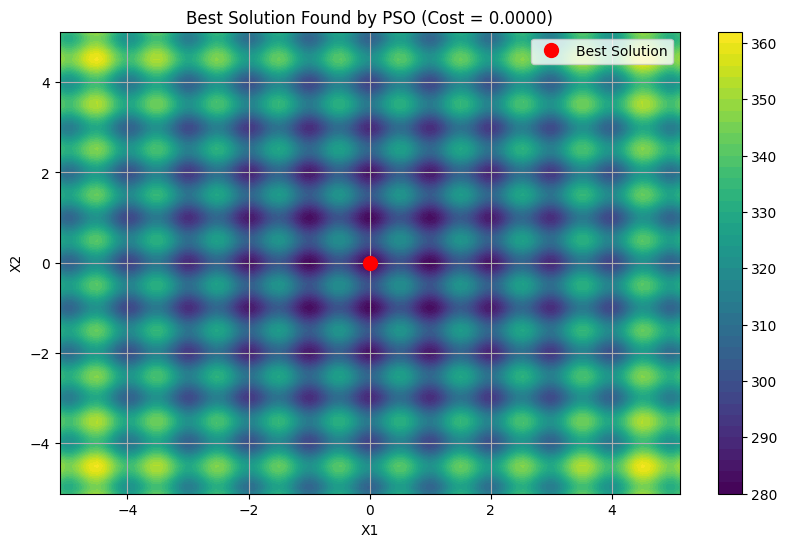

In [68]:
# Plot the best solution found by PSO in a 2D plot

def plot_solution_2d_pso(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by PSO (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for PSO
plot_solution_2d_pso(best_solution, best_cost)

### GA

In [69]:
from niapy.problems import Problem
from geneticalgorithm import geneticalgorithm as ga

In [71]:
def ga_objective(params, fun_index):
    """
    Objective function to evaluate GA performance with given parameters.

    Parameters:
    - params: List of GA parameters [max_num_iterations, population_size, crossover_rate, mutation_rate].

    Returns:
    - best_cost: The best cost achieved by GA with the given parameters.
    """
    max_num_iterations = int(params[0])  # Maximum number of iterations
    population_size = int(params[1])     # Population size
    crossover_rate = params[2]           # Crossover rate
    mutation_rate = params[3]            # Mutation rate

    # Test function setup
    function, var_min, var_max, var_number = select_test_function(fun_index)

    # Set GA algorithm parameters
    varbound = np.array([[var_min, var_max]] * var_number)  # Bounds for each parameter
    algorithm_params = {
    "max_num_iteration": max_num_iterations,
    "population_size": population_size,
    "mutation_probability": mutation_rate,
    "elit_ratio": 0.01,
    "crossover_probability": crossover_rate,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None}
    
    # Initialize and run the GA algorithm
    ga_model = ga(function=function, dimension=var_number, variable_type='real', 
                  variable_boundaries=varbound, algorithm_parameters=algorithm_params, convergence_curve=False, progress_bar=False)
    
    # Run the GA and get the best cost
    ga_model.run()
    
    best_cost = ga_model.output_dict['function']  # Extract the best cost
    return best_cost  # Return the best cost as the objective value

In [73]:
class GAParamOptimization(Problem):
    def __init__(self, fun_index):
        # Define the dimension (3 parameters: max_num_iteration, population_size, crossover_rate, mutation_rate)
        super().__init__(dimension=4, lower=[10, 10, 0.1, 0.1], upper=[100, 100, 1.0, 1.0])
        self.fun_index = fun_index

    def _evaluate(self, x):
        # Call the GA objective function
        return ga_objective(x, self.fun_index)
    
# Create a task for the GA parameter optimization
task_ga = Task(problem=GAParamOptimization(fun_index), max_evals=50)  # Set maximum evaluations

# Initialize and run the ABC algorithm for GA
abc_ga = ArtificialBeeColonyAlgorithm(population_size=20)
best_params_ga, best_cost_ga = abc_ga.run(task=task_ga)

print(f"Optimized GA Parameters: {best_params_ga}")
print(f"Best Cost Achieved by GA: {best_cost_ga}")

 The best solution found:
 [ 1.07166198  0.0894685   4.10189231  0.10008745  2.21924468 -0.10437489
 -2.03216577  0.94304119 -0.88956345 -2.99353147 -2.95410159 -1.84538623
  3.19594758  0.27923353 -1.1320872  -1.93935565  0.05977745 -4.09477181
  0.05630094 -1.17995343 -2.02861391 -0.75114721 -0.01832344  0.92837718
  1.88836533 -0.11911333  1.175741   -2.76838612 -0.12423886 -0.99975805]

 Objective function:
 191.69676295783813
 The best solution found:
 [-0.21542633  1.07526308 -1.27720798  1.22993247  1.34610894  1.72786501
  0.16666255  0.98630378 -0.85950023  0.71018997 -0.2643745  -2.94015347
 -0.03044677 -1.10880146 -0.85647164 -0.16985793  1.11599294 -1.0704713
  1.51653074 -0.00900414  1.97264395 -1.74822288  0.15547177  0.1029876
  0.94522854  0.30348796 -0.67199003 -0.20227096 -0.37738195 -2.00012012]

 Objective function:
 232.9698803233858
 The best solution found:
 [-1.52284275e+00  3.03322587e+00  1.08244972e+00  1.95901899e+00
  2.21501641e+00 -2.24035515e-03  2.14456

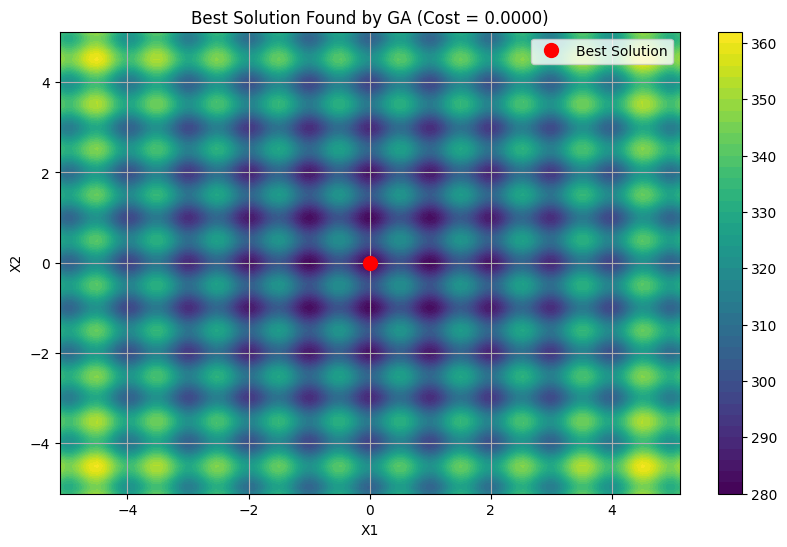

In [74]:
# Plot the best solution found by GA in a 2D plot

def plot_solution_2d_ga(best_solution, best_cost):
    # Get the test function and its parameter ranges
    function, var_min, var_max, var_number = select_test_function(fun_index)
    
    # Convert var_min and var_max to arrays
    var_min = np.array([var_min] * var_number)
    var_max = np.array([var_max] * var_number)
    
    # Set up 2D grid for plotting
    x = np.linspace(var_min[0], var_max[0], 100)
    y = np.linspace(var_min[1], var_max[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Compute the function values for the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            Z[i, j] = function(point)
    
    # Plot the function and the best solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.plot(best_solution[0], best_solution[1], 'ro', markersize=10, label='Best Solution')
    plt.title(f'Best Solution Found by GA (Cost = {best_cost:.4f})')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar()
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the 2D plotting function for GA
plot_solution_2d_ga(best_solution, best_cost)

## Comparing the metaheuristics